##Melbourne Housing Project
###Content
0. Import library & utils
1. Descriptive analysis
2. Apply linear regression model for prediction with hold out & cross validation
3. Apply linear regression model for prediction with hold out & cross validation - using PCA
4. Visualize residential & homoscedasticity
5. Tune parameter of linear regression model
6. Write up analysis for each section
7. Summary

#### Data definition on Kaggle
Some Key Details

Suburb: Suburb

Address: Address

Rooms: Number of rooms

Price: Price in Australian dollars

Method: 
S - property sold; 
SP - property sold prior; 
PI - property passed in; 
PN - sold prior not disclosed; 
SN - sold not disclosed; 
NB - no bid; 
VB - vendor bid; 
W - withdrawn prior to auction; 
SA - sold after auction; 
SS - sold after auction price not disclosed. 
N/A - price or highest bid not available.

Type:
br - bedroom(s); 
h - house,cottage,villa, semi,terrace; 
u - unit, duplex;
t - townhouse; 
dev site - development site; 
o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD in Kilometres

Regionname: General Region (West, North West, North, North east …etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size in Metres

BuildingArea: Building Size in Metres

YearBuilt: Year the house was built

CouncilArea: Governing council for the area

Lattitude: Self explanitory

Longtitude: Self explanitory

### 0. Import library & utils

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import math
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder

##### utils

In [14]:
def box_cox_transfrom(df,train_var,pred_var):
  bx = PowerTransformer(method='box-cox')
  train_list = np.array(df[train_var]).reshape(-1,1)
  bx_transform = bx.fit(train_list)
  return bx_transform.transform(np.array(df[pred_var]).reshape(-1,1))+100

def col_filtering(df,col):
  list_col = ['Lattitude','Longtitude']
  if col in list_col:
    temp_list = df
    temp_list[col] = round(abs(temp_list[col]),4)
    temp_list = temp_list[temp_list[col]>0]
  else:
    temp_list = df[df[col]>0]
  return temp_list

###1. Descriptive analysis
#### Inclduing:
####1.1 Describe data and null handling
####1.2 Visualize and correlation finding

In [3]:
# Import data & examine data inteity
df = pd.read_csv('Melbourne_housing_FULL.csv')
print(df.shape)
df.info()
df.describe()

(34857, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


In [4]:
df.isnull().sum()/(df.shape[0])

Suburb           0.000000
Address          0.000000
Rooms            0.000000
Type             0.000000
Price            0.218321
Method           0.000000
SellerG          0.000000
Date             0.000000
Distance         0.000029
Postcode         0.000029
Bedroom2         0.235735
Bathroom         0.235993
Car              0.250394
Landsize         0.338813
BuildingArea     0.605761
YearBuilt        0.553863
CouncilArea      0.000086
Lattitude        0.228821
Longtitude       0.228821
Regionname       0.000086
Propertycount    0.000086
dtype: float64

#####+Remark
######1. Data has 21 columns & 34857 rows.
######2. Columns with null value: Price (27247/34857), Distant (34856/34857), Postcode (34856/34857), Bedroom2 (26640/34857), Bathroom (26631/34857), Car (26129/34857), Landsize (23047/34857), Buiding Area (13742/34857), Yearbuild (15551/34857), CouncilArea (34854/34857), Lattitue (26881/34857), Longtitue (26881/34857), Regionname (34854/34857), Propertycount (34854/34857)
    ----> Drop row for null value at columns: Distance, Postcode, CouncilArea, Regionname, Propertycount
    ----> Fill Null value for Price, Bedroom2, Bathroom, Car, Landsize, BuildingArea, Yearbuild, Lat/long

######3. Zero-value columns: Distance, Bedrooms2, Bathroom, Car, Landsize, Buiding Area ---> go deep dive to see whether abnormal to handle.


In [5]:
# drop null rows
drop_col = ['Distance','Postcode','CouncilArea','Regionname','Propertycount']
for c in drop_col:
  df.drop(df[df[c].isnull()].index, inplace=True)
df[drop_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34854 entries, 0 to 34856
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Distance       34854 non-null  float64
 1   Postcode       34854 non-null  float64
 2   CouncilArea    34854 non-null  object 
 3   Regionname     34854 non-null  object 
 4   Propertycount  34854 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.8+ MB


In [6]:
# fill na
fill_col = ['Price', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'Lattitude','Longtitude']
print("======="+"Mode"+"=======")
print(df[fill_col].mode().T)
print(df['YearBuilt'].mode().T)
print("======="+"Quantile"+"=======")
print(df[fill_col[0:4]].describe())
print(df[fill_col[5:8]].describe())

=======Mode=======
                        0          1
Price         600000.0000  1100000.0
Bedroom2           3.0000        NaN
Bathroom           1.0000        NaN
Car                2.0000        NaN
Landsize           0.0000        NaN
BuildingArea     120.0000        NaN
Lattitude        -37.8361        NaN
Longtitude       144.9966        NaN
0    1970.0
dtype: float64
=======Quantile=======
              Price      Bedroom2      Bathroom           Car
count  2.724400e+04  26640.000000  26631.000000  26129.000000
mean   1.050210e+06      3.084647      1.624798      1.728845
std    6.414923e+05      0.980690      0.724212      1.010771
min    8.500000e+04      0.000000      0.000000      0.000000
25%    6.350000e+05      2.000000      1.000000      1.000000
50%    8.700000e+05      3.000000      2.000000      2.000000
75%    1.295000e+06      4.000000      2.000000      2.000000
max    1.120000e+07     30.000000     12.000000     26.000000
       BuildingArea     Lattitude    Lon

========Distribution column: Price========


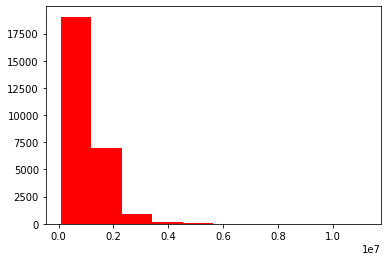

========Distribution column: Bedroom2========


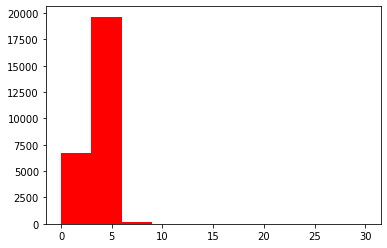

========Distribution column: Bathroom========


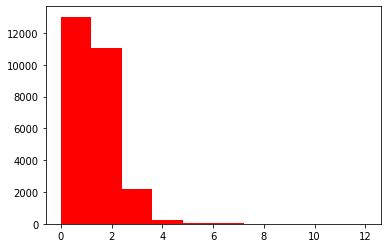

========Distribution column: Car========


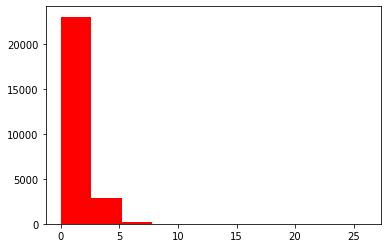

========Distribution column: Landsize========


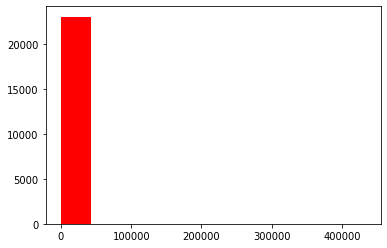

========Distribution column: BuildingArea========


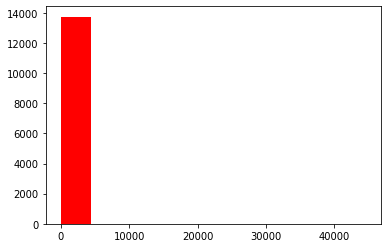

========Distribution column: Lattitude========


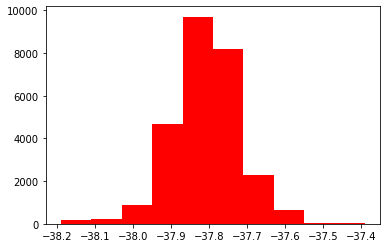

========Distribution column: Longtitude========


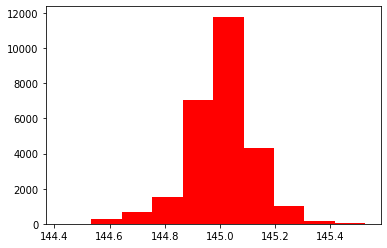

In [7]:
for col in fill_col:
  temp_df = df[df[col].notnull()]
  trg_array = np.array(temp_df[col])
  print("========Distribution column: " + col + "========")
  plt.hist(temp_df[col],color='red')
  plt.show()

######+ Remark
######- We have 2 groups to fill null value
######--> group1: fill by median: Price,Bedroom2,Bathroom,Car,BuildingArea since the distribution of those columns are skewed.
######--> group2: fill by mean: Lattitude,Longtitude since the distribution of those columns are normal.
######- For columns YearBuilt, the missing value account for >50% and this feature is kind of time series value so we will ignore/drop this columns as well and not fill with statistical method to avoid the impact of 1 undefined group to final result.


In [8]:
fill_med = ['Price','Bedroom2','Bathroom','Car','Landsize','BuildingArea']
fill_mean = ['Lattitude','Longtitude']
for c in fill_col:
  if c in fill_med:
    df[c].fillna(df[c].median(), inplace=True)
  elif c in fill_mean:
    df[c].fillna(df[c].mean(), inplace=True)
df[fill_col].info()
df[fill_col].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34854 entries, 0 to 34856
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         34854 non-null  float64
 1   Bedroom2      34854 non-null  float64
 2   Bathroom      34854 non-null  float64
 3   Car           34854 non-null  float64
 4   Landsize      34854 non-null  float64
 5   BuildingArea  34854 non-null  float64
 6   Lattitude     34854 non-null  float64
 7   Longtitude    34854 non-null  float64
dtypes: float64(8)
memory usage: 3.6 MB


,Price,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude
count,3.485400e+04,34854.000000,34854.000000,34854.000000,34854.000000,34854.000000,34854.000000,34854.000000
mean,1.010863e+06,3.064698,1.713318,1.796723,569.005652,145.563650,-37.810634,145.001851
std,5.720167e+05,0.858127,0.652777,0.883005,2764.026645,252.233483,0.079283,0.105532
min,8.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,-38.190430,144.423790
25%,6.950000e+05,3.000000,1.000000,1.000000,357.000000,136.000000,-37.846900,144.964400
50%,8.700000e+05,3.000000,2.000000,2.000000,521.000000,136.000000,-37.810634,145.001851
75%,1.150000e+06,3.000000,2.000000,2.000000,598.000000,136.000000,-37.770893,145.051750
max,1.120000e+07,30.000000,12.000000,26.000000,433014.000000,44515.000000,-37.390200,145.526350


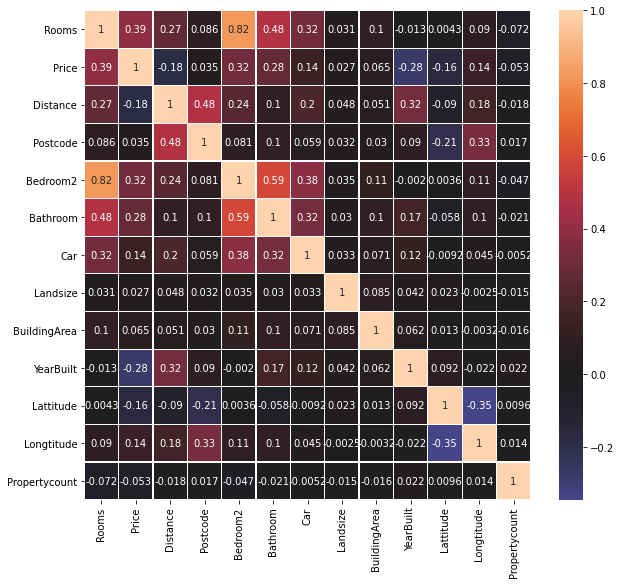

In [9]:
#zero value check
#Correlation draft check
plt.figure(figsize=(10,9))
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0,  annot= True, linewidths=0.1 )

######+Remark for zero-value columns: 
######1. For Bedroom2, Bathroom, Car: based on definition of data & correlation matrix, these columns have high correlation with Rooms --> these columns is to additional for Rooms so it is ok to keep it unchanged.
######2. For Landsize, BuildingArea: These columns are related to sizing and there is no record with both of these columns with zero --> keep unchanged as well.

###2. Apply linear regression model for prediction with hold out & cross validation

######+ Remark:
######1. Check detail of correlation btw Price & Others/ ANOVA Test with variables Method & Type -> pick feature
######2. Training LR model

====== Normal Distribution & Correlation with Price: Rooms======


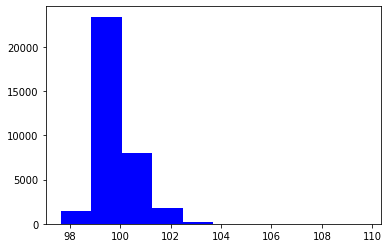

Correlation Coef: 0.4750863760247491


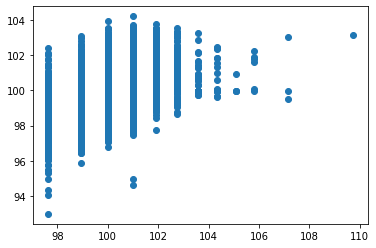

====== Normal Distribution & Correlation with Price: Price======


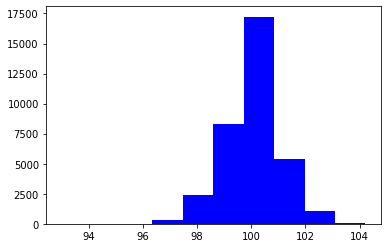

Correlation Coef: 1.0


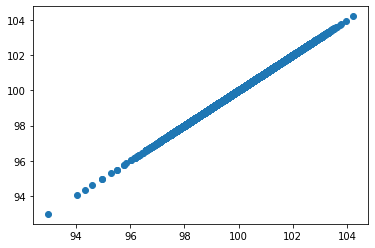

====== Normal Distribution & Correlation with Price: Distance======


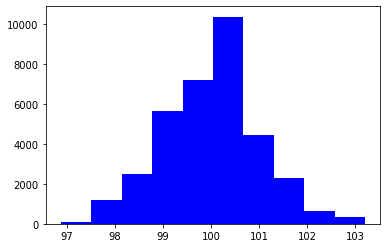

Correlation Coef: -0.15232828644719792


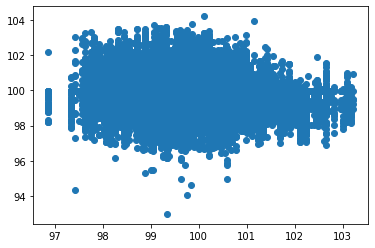

====== Normal Distribution & Correlation with Price: Postcode======


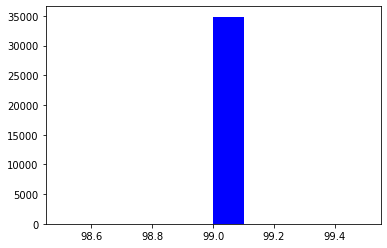

Correlation Coef: nan


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


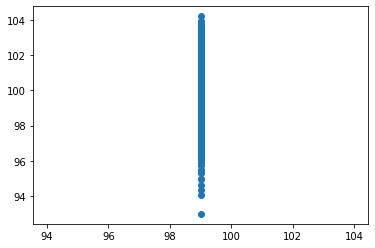

====== Normal Distribution & Correlation with Price: Bedroom2======


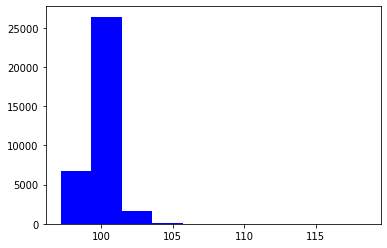

Correlation Coef: 0.37891231464784764


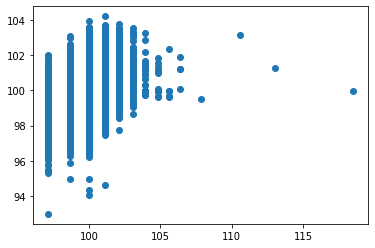

====== Normal Distribution & Correlation with Price: Bathroom======


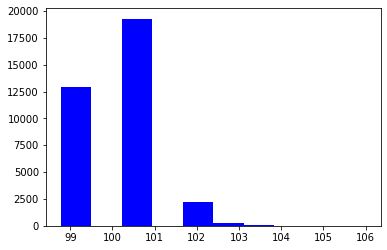

Correlation Coef: 0.24574187407394643


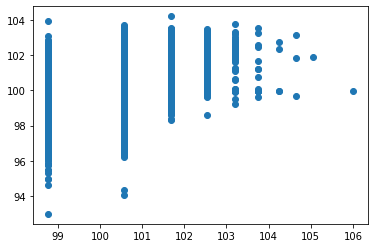

====== Normal Distribution & Correlation with Price: Car======


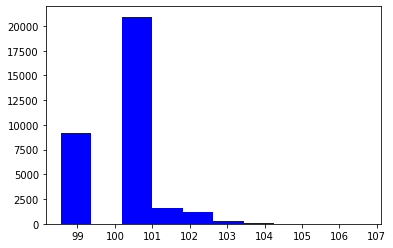

Correlation Coef: 0.20632102622981016


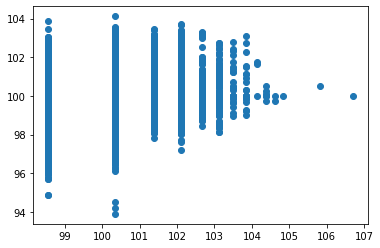

====== Normal Distribution & Correlation with Price: Landsize======


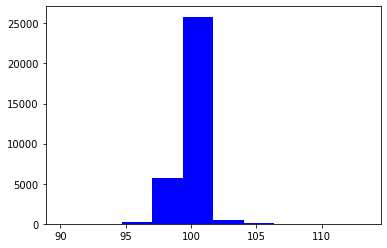

Correlation Coef: 0.05539752861343227


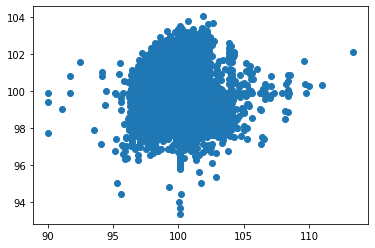

====== Normal Distribution & Correlation with Price: BuildingArea======


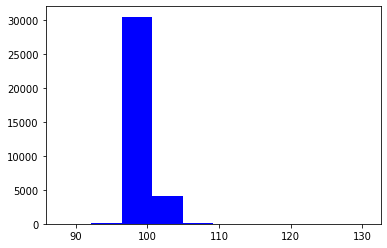

Correlation Coef: 0.2896569348213635


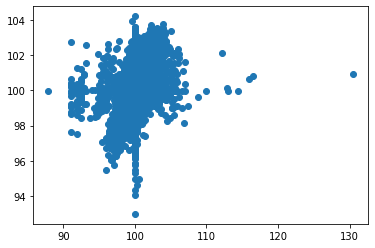

====== Normal Distribution & Correlation with Price: Lattitude======


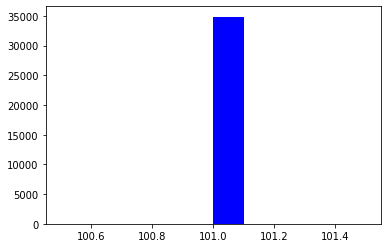

Correlation Coef: nan


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


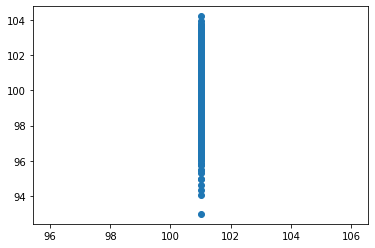

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


====== Normal Distribution & Correlation with Price: Longtitude======


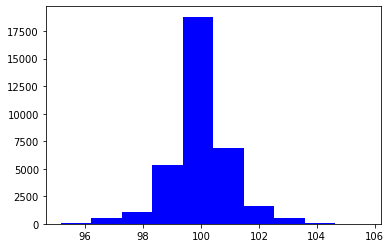

Correlation Coef: 0.19016858548433607


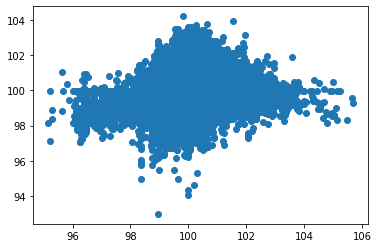

====== Normal Distribution & Correlation with Price: Propertycount======


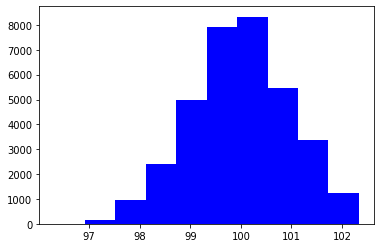

Correlation Coef: -0.04649619911832238


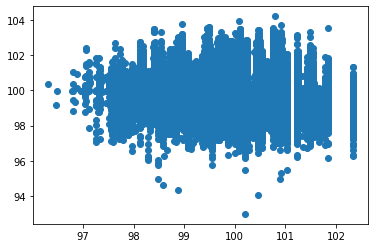

In [12]:
#Check correlation btw price and the rest
list_of_corr_col = df.select_dtypes(include=['float64','int64']).columns.tolist()

for key in [list_of_corr_col for list_of_corr_col in list_of_corr_col if list_of_corr_col not in ['YearBuilt']]:
  temp_list = col_filtering(df,key)
  var_price = box_cox_transfrom(temp_list,'Price','Price')
  var_target = box_cox_transfrom(temp_list,key,key)
  print("====== Normal Distribution & " + "Correlation with Price: " + key + "======")
  plt.hist(var_target,color='blue')
  plt.show()
  # print("Correlation sco: Price & "+key+"======")
  # print(np.corrcoef(var_price,var_target,rowvar=False)[0][1])
  print("Correlation Coef: " + str(np.corrcoef(var_price,var_target,rowvar=False)[0][1]))
  plt.scatter(var_target,var_price)
  plt.show()

In [15]:
# ANOVA Test for METHOD & TYPE
# H0: There is the different btw each METHOD/TYPE
# H1: No different
## Column Method
list_of_method = list(set(df['Method'].tolist()))
list_of_method
n ={}
for key in list_of_method:
  temp_df = df[df['Method']==key]
  transform_array = box_cox_transfrom(temp_df,'Price','Price')
  print(key)
  n[key] = transform_array.tolist()

# f_oneway(n['AU'],n['CA'],n['DE'],n['FR'],n['GB'],n['Others'],n['US'])


S


ValueError: ignored